In [1]:
# Importações

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn import svm
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    cohen_kappa_score,
    roc_auc_score,
    confusion_matrix
)

import pandas as pd
import numpy as np

from nltk.corpus import stopwords

import re

import itertools

# Cross validate

from sklearn.model_selection import cross_validate, cross_val_score

# Modelos

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt

/home/ABTLUS/pedro220058/.local/lib/python3.10/site-packages/nltk/metrics/association.py:26: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.21.6)
  from scipy.stats import fisher_exact


In [2]:
# Importação do Dataframe contendo títulos de notícias relacionadas a saúde.

dataframe = pd.read_csv('../combined_df.zip')

display(dataframe)

,title,link,date,Site,noticia_falsa,corpo_texto
0,"Ken Frazier, Merck, disse pressa vacinar liber...",https://www.boatos.org/saude/ken-frazier-merck...,30/10/2020,NaN,0,“ prometer vacinar covid gravar desserviço o o...
1,Coronavírus: Últimas notícias sabemos sexta-fe...,https://noticias.uol.com.br/saude/ultimas-noti...,08/05/2020 13h09Atualizada em 08/05/2020 22h35,NaN,1,particularidade perigoso o brasil pandemia cor...
2,menino indiano prever coronavírus antar pandemia,https://www.e-farsas.com/um-menino-indiano-pre...,24/06/2020,NaN,0,o história ganhar fama rede social e diverso s...
3,Tuíte engana afirmar sol mata coronavírus,https://projetocomprova.com.br/publicações/tui...,2020/09/10,NaN,0,tuíte referência o estimativo estudar basear m...
4,Vietnã isola cidade registrou surto covid após...,https://noticias.uol.com.br/ultimas-noticias/e...,28/07/2020 18h46,NaN,1,O Vietnã suspendeu a partir de hoje todas as r...
...,...,...,...,...,...,...
4764,Marcos Pontes voluntário testes medicamento co...,https://noticias.uol.com.br/politica/ultimas-n...,31/07/2020 11h21,NaN,1,o ministrar ciência tecnologia e inovação marc...
4765,feirar chinês vender rato morcego origem coron...,https://www.e-farsas.com/feira-chinesa-vende-r...,29/01/2020,NaN,0,o vídeo minuto duração e espalhar rapidamente ...
4766,Não evidências científicas sobre necessidade t...,https://checamos.afp.com//nao-ha-evidencias-ci...,4/06/2021 às 22:25,NaN,0,“ trocar escovar covid-19 precisar trocar esco...
4767,Coronavírus atual pode versão contagiosa origi...,https://www.uol.com.br/vivabem/noticias/afp/20...,02/07/2020 21h06Atualizada em 03/07/2020 09h02,NaN,1,o variante sars-cov-2 dominante infecto célula...


In [3]:
# Cria dataframe para processamento
df = dataframe.copy()
df_sorted = df.sort_values(by='noticia_falsa').reset_index(drop=True)

# Transformar a coluna título em string
df_sorted['title'] = df_sorted['title'].astype(str)

In [4]:
### Filtrando notícias com valores 0 e 1
noticias_falsa_0 = df_sorted[df_sorted['noticia_falsa'] == 0]
noticias_falsa_1 = df_sorted[df_sorted['noticia_falsa'] == 1] # Aqui estão representadas as notícias verdadeiras

### Selecionar, aleatoriamente, 1000 notícias com valores 0 e 1500 com valores 1
amostra_0 = noticias_falsa_0.sample(n=1000, random_state=42)
amostra_1 = noticias_falsa_1.sample(n=1500, random_state=42)

# Criando um novo dataframe com estas notícias
novo_df = pd.concat([amostra_0, amostra_1])

# Resetando o index
novo_df = novo_df.sample(frac=1, random_state=24).reset_index(drop=True)

display(novo_df)

,title,link,date,Site,noticia_falsa,corpo_texto
0,Ministro britânico Saúde nega ter mentido sobr...,https://noticias.uol.com.br/ultimas-noticias/a...,27/05/2021 09h01,NaN,1,o ministrar britânico saudar matt hancock nega...
1,Covid-19: entidade orienta sobre vacinação pac...,https://www.uol.com.br/vivabem/noticias/redaca...,17/01/2021 10h22,NaN,1,o sbr sociedade brasileiro reumatologia lançar...
2,Exército construiu 2.000 leitos hospital apena...,https://www.boatos.org/saude/exercito-construi...,05/04/2020,NaN,0,chino 1.000 leito dia x exército brasil 2.000 ...
3,Vacina indiana contra covid: alvo rede privada...,https://www.uol.com.br/vivabem/noticias/bbc/20...,04/01/2021 08h31,NaN,1,Especialistas em doenças infecciosas estão man...
4,nasce diagnóstico psiquiátrico?,https://medicospelavidacovid19.com.br/opiniao/...,Data não disponível,Médicos Pela Vida,0,"['nasce', 'diagnóstico', 'psiquiátrico', 'skip..."
...,...,...,...,...,...,...
2495,Infectologista prevê variante Manaus predomina...,https://noticias.uol.com.br/saude/ultimas-noti...,29/01/2021 10h37,NaN,1,"O infectologista Marcus Lacerda, da Fiocruz-AM..."
2496,Dilma disse vacina chinesa vai funcionar porqu...,https://projetocomprova.com.br/publicações/dil...,2020/10/29,NaN,0,o postagem verificar inventar declaração o efi...
2497,Especialistas pedem atenção saúde mental confi...,https://www.uol.com.br/vivabem/noticias/afp/20...,19/04/2020 11h45,NaN,1,consequência psíquico confinamento afeta quase...
2498,É falso nova lei acabe obrigatoriedade uso más...,https://noticias.uol.com.br/confere/ultimas-no...,27/10/2020 04h00,NaN,0,imagem circular whatsapp espalhar mentira o le...


In [5]:
# Agora, separaremos uma porção para validação com dados externos

### Separar as notícias restantes
restantes_0 = noticias_falsa_0.drop(amostra_0.index)
restantes_1 = noticias_falsa_1.drop(amostra_1.index)

# Selecionar 449 notícias restantes com valor 0 e 800 com valor 1
amostra_0_restante = restantes_0.sample(n=449, random_state=42)
amostra_1_restante = restantes_1.sample(n=800, random_state=42)

# Criar um novo dataframe
segundo_df = pd.concat([amostra_0_restante, amostra_1_restante])

# Bagunçar o df
segundo_df = segundo_df.sample(frac=1, random_state=48).reset_index(drop=True)

display(segundo_df)

,title,link,date,Site,noticia_falsa,corpo_texto
0,Presidente Pfizer recusa suspender patentes va...,https://noticias.uol.com.br/ultimas-noticias/a...,06/05/2021 14h12Atualizada em 06/05/2021 18h59,NaN,1,o presidente pfizer albert bourla n quinta-fei...
1,Caixa abre duas horas cedo partir segunda evit...,https://economia.uol.com.br/noticias/redacao/2...,03/05/2020 14h19,NaN,1,o d segunda-feira o caixa antecipar horar o ab...
2,Teich: 'Brasil países melhor performa relação ...,https://noticias.uol.com.br/saude/ultimas-noti...,22/04/2020 18h09Atualizada em 22/04/2020 19h45,NaN,1,o ministrar saudar nelson teich hoje coletiva ...
3,defendeu,https://www.cnnbrasil.com.br/saude/exigencia-d...,2024-09-03T14:22:41-03:00,Médicos Pela Vida,0,"['exigência', 'passaporte', 'vacinal', 'respei..."
4,vacinação,https://www.gov.br/saude/pt-br/vacinacao,Data não disponível,Gov - Fake,0,"['vacinação', 'ministério', 'saúde', 'ir', 'co..."
...,...,...,...,...,...,...
1244,CoronaVac deve ter eficácia similar adultos id...,https://www.uol.com.br/vivabem/reuters/2020/12...,29/12/2020 18h48,NaN,1,"A CoronaVac, vacina contra Covid-19 do laborat..."
1245,"Brasil pode ganhar R$ 2,8 trilhões 'economia v...",https://economia.uol.com.br/noticias/estadao-c...,13/08/2020 07h50,NaN,1,o movimentar recuperação economia o abalar pro...
1246,Coronavírus: uso máscaras comércio passa obrig...,https://noticias.uol.com.br/saude/ultimas-noti...,11/05/2020 08h48Atualizada em 11/05/2020 08h53,NaN,1,tornar obrigatório o máscara transportar públi...
1247,"porque nós, mpv, criamos aba ‘fact checking’",https://medicospelavidacovid19.com.br/editoria...,Data não disponível,Médicos Pela Vida,0,"['porque', 'mpv', 'criamos', 'aba', 'fact', 'c..."


In [6]:
# Checar os títulos únicos em cada Dataframe

corpo_texto_novo_df = set(novo_df['corpo_texto'].unique())
corpo_texto_segundo_df = set(segundo_df['corpo_texto'].unique())

# Vendo se há títulos repetidos

corpo_texto_repetidos = corpo_texto_novo_df.intersection(corpo_texto_segundo_df)

print(f"Corpos do texto repetidos: {corpo_texto_repetidos}")

# Remover do 'segundo_df' os títulos repetidos

segundo_df_filtrado = segundo_df[~segundo_df['corpo_texto'].isin(corpo_texto_novo_df)]

segundo_df_filtrado = segundo_df_filtrado.reset_index(drop=True)

display(segundo_df_filtrado)

Corpos do texto repetidos: {"['página', 'encontrada', 'mpv', 'skip', 'to', 'content', 'home', 'últimas', 'editoriais', 'artigos', 'estudos', 'fact', 'checking', 'análises', 'vídeos', 'associese', 'estados', 'abaixo', 'assinado', 'carta', 'brasil', '2021', 'movimento', 'legislação', 'vida', 'excelentíssimos', 'membros', 'poder', 'judiciário', 'ministério', 'público', 'médicos', 'jornada', 'manifestos', 'manifestos', 'regionais', 'sugestões', 'imed', 'suporte', 'contato', 'help', 'desk', 'página', 'encontrada', 'página', 'existe', 'removida', 'continue', 'navegando', 'através', 'menu', 'acima', 'atacar', 'médicos', 'independentes', 'estadão', 'dá', 'voz', 'patrocinados', 'big', 'pharma', '3', 'setembro', '2024', 'além', 'consultados', 'suposta', 'checagem', 'fatos', 'próprio', 'jornal', 'possui', 'relações', 'umbilicais', 'grandes', 'corporações', 'farmacêuticas', 'internacionais', 'covid19', 'estudo', 'falso', 'atacava', 'hidroxicloroquina', 'virou', 'manchete', 'brasil', 'todo', 'retir

,title,link,date,Site,noticia_falsa,corpo_texto
0,Presidente Pfizer recusa suspender patentes va...,https://noticias.uol.com.br/ultimas-noticias/a...,06/05/2021 14h12Atualizada em 06/05/2021 18h59,NaN,1,o presidente pfizer albert bourla n quinta-fei...
1,Caixa abre duas horas cedo partir segunda evit...,https://economia.uol.com.br/noticias/redacao/2...,03/05/2020 14h19,NaN,1,o d segunda-feira o caixa antecipar horar o ab...
2,Teich: 'Brasil países melhor performa relação ...,https://noticias.uol.com.br/saude/ultimas-noti...,22/04/2020 18h09Atualizada em 22/04/2020 19h45,NaN,1,o ministrar saudar nelson teich hoje coletiva ...
3,defendeu,https://www.cnnbrasil.com.br/saude/exigencia-d...,2024-09-03T14:22:41-03:00,Médicos Pela Vida,0,"['exigência', 'passaporte', 'vacinal', 'respei..."
4,vacinação,https://www.gov.br/saude/pt-br/vacinacao,Data não disponível,Gov - Fake,0,"['vacinação', 'ministério', 'saúde', 'ir', 'co..."
...,...,...,...,...,...,...
1241,CoronaVac deve ter eficácia similar adultos id...,https://www.uol.com.br/vivabem/reuters/2020/12...,29/12/2020 18h48,NaN,1,"A CoronaVac, vacina contra Covid-19 do laborat..."
1242,"Brasil pode ganhar R$ 2,8 trilhões 'economia v...",https://economia.uol.com.br/noticias/estadao-c...,13/08/2020 07h50,NaN,1,o movimentar recuperação economia o abalar pro...
1243,Coronavírus: uso máscaras comércio passa obrig...,https://noticias.uol.com.br/saude/ultimas-noti...,11/05/2020 08h48Atualizada em 11/05/2020 08h53,NaN,1,tornar obrigatório o máscara transportar públi...
1244,"porque nós, mpv, criamos aba ‘fact checking’",https://medicospelavidacovid19.com.br/editoria...,Data não disponível,Médicos Pela Vida,0,"['porque', 'mpv', 'criamos', 'aba', 'fact', 'c..."


In [7]:
# Variáveis para padronização/configuração

scores = ['accuracy', 'precision', 'roc_auc']
usar_links = False

In [8]:
# Checar se há títulos vazios
non_empty_titles = novo_df['corpo_texto'].apply(lambda x: len(x.strip()) > 0)
non_empty_links = novo_df['link'].apply(lambda x: len(x.strip()) > 0)

# Checar o resultado
print(non_empty_titles.head())
print("Há documentos vazios?", not non_empty_titles.all())
print("Há links vazios?", not non_empty_links.all())
print("Número de documentos vazios:", (~non_empty_titles).sum())
print("Número de links vazios:", (~non_empty_links).sum())

0    True
1    True
2    True
3    True
4    True
Name: corpo_texto, dtype: bool
Há documentos vazios? False
Há links vazios? False
Número de documentos vazios: 0
Número de links vazios: 0


In [9]:
# Iniciar o processo de TF-IDF
tfidf_vectorizer = TfidfVectorizer()

# Nesta célula, será aplicado o TF-IDF aos títulos das notícias, caso não haja nenhum vazio
temp_tit = novo_df['corpo_texto'].tolist()
if non_empty_titles.all():
    titles_tfidf = tfidf_vectorizer.fit_transform(temp_tit)
    print('TF-IDF aplicado com sucesso.')
    tfidf = titles_tfidf
else:
    print('Há documentos vazios ou apenas stop words.')

TF-IDF aplicado com sucesso.


In [10]:
def split_and_clean(link):
# Dividir o link por '/', '-', '%', '.', e ':'
    words = re.split(r'[/\-\%\.\:\_]', link)
    # Remover palavras indesejadas, stopwords e letras isoladas, mantendo acentos
    unwanted = {'https', 'www', 'com', 'br', 'pt', 'html', 'htm', 'ghtml', 'php'}
    cleaned_words = [
    word for word in words
    if not any(unwanted_word in word.lower() for unwanted_word in unwanted)
    and len(word) > 1
    ]
    return cleaned_words

if usar_links:

    # Tratando os links
    df['processed_links'] = df['link'].apply(split_and_clean)

    # TF-IDF para os combinação título e link
    temp_link = [' '.join(i) for i in df['processed_links']]
    temp_tit_link = [' '.join(list(a)) for a in zip(temp_tit, temp_link)]
    print(temp_tit_link)
    if non_empty_links.all():
        tit_link_tfidf = tfidf_vectorizer.fit_transform(temp_tit_link)
        print('TF-IDF aplicado com sucesso.')
        tfidf = tit_link_tfidf
    else:
        print('Há items vazios ou apenas stop words.')

In [11]:
# Criação de vetores
X = tfidf
y = novo_df['noticia_falsa']

corpos_texto = novo_df['corpo_texto'].tolist()

print("Dimensões de X:", X.shape)
print("Dimensões de y:", y.shape)

Dimensões de X: (2500, 27889)
Dimensões de y: (2500,)


In [12]:
# Padronizando scores para todos os modelos.

scores = ['accuracy', 'precision', 'roc_auc']

### Árvore de Decisão

In [13]:
# Cria modelo
modelo_ad = DecisionTreeClassifier()
modelo_ad

# Validação cruzada
resultados_ad = cross_validate(modelo_ad, X, y, scoring=scores)

acc_ad = resultados_ad['test_accuracy'].mean()
prec_ad = resultados_ad['test_precision'].mean()
rocauc_ad = resultados_ad['test_roc_auc'].mean()
print(f'Acurácia: {acc_ad:.3f}\nPrecisão: {prec_ad:.3f}\nROC-AUC: {rocauc_ad:.3f}')

Acurácia: 0.856
Precisão: 0.882
ROC-AUC: 0.850


### Floresta Aleatória

In [14]:
# Cria modelo
modelo_rf = RandomForestClassifier()
modelo_rf

# Validação cruzada
resultados_rf = cross_validate(modelo_rf, X, y, scoring=scores)

acc_rf = resultados_rf['test_accuracy'].mean()
prec_rf = resultados_rf['test_precision'].mean()
rocauc_rf = resultados_rf['test_roc_auc'].mean()
print(f'Acurácia: {acc_rf:.3f}\nPrecisão: {prec_rf:.3f}\nROC-AUC: {rocauc_rf:.3f}')

Acurácia: 0.937
Precisão: 0.931
ROC-AUC: 0.986


### Regressão Logística

In [15]:
# Cria modelo
modelo_lr = LogisticRegression()
modelo_lr

# Validação cruzada
resultados_lr = cross_validate(modelo_lr, X, y, scoring=scores)

acc_lr = resultados_lr['test_accuracy'].mean()
prec_lr = resultados_lr['test_precision'].mean()
rocauc_lr = resultados_lr['test_roc_auc'].mean()
print(f'Acurácia: {acc_lr:.3f}\nPrecisão: {prec_lr:.3f}\nROC-AUC: {rocauc_lr:.3f}')

Acurácia: 0.926
Precisão: 0.904
ROC-AUC: 0.982


### SVC

In [16]:
# Parâmetros
C = 77
kernel = 'rbf'
gamma = 0.01

# Cria modelo
modelo_svm = svm.SVC(C=C, kernel=kernel, gamma=gamma)

# Validação cruzada
resultados_svm = cross_validate(modelo_svm, X, y, scoring=scores)

acc_svm = resultados_svm['test_accuracy'].mean()
prec_svm = resultados_svm['test_precision'].mean()
rocauc_svm = resultados_svm['test_roc_auc'].mean()
print(f'Acurácia: {acc_svm:.3f}\nPrecisão: {prec_svm:.3f}\nROC-AUC: {rocauc_svm:.3f}')

Acurácia: 0.942
Precisão: 0.942
ROC-AUC: 0.984


### Função de comparação

In [19]:
stop_words = set(stopwords.words('portuguese'))

def trata_padrao(titulo, usar_links=False, link=None):
    '''
    Função para padronizar o tratamento dos títulos.

    Args:
    titulo (str) = título da notícia
    usar_links (bool) = usar ou não o link
    link (str) = link da notícia
    '''

    # Pré-processamento do titulo

    titulo = str(titulo).lower()
    titulo = nltk.word_tokenize(titulo)
    titulo = [word for word in titulo if word not in stop_words]
    titulo = [' '.join(titulo)]
    temp_tit = titulo

    # se usar link, pre processar link
    if usar_links:
        link = [split_and_clean(link)]
        temp_link = [' '.join(i) for i in link]
        print(temp_tit,temp_link)
        temp_tit_link = [' '.join(list(a)) for a in zip(temp_tit, temp_link)]
        processed = temp_tit_link
    else:
        processed = titulo

    return processed

In [20]:
# Define modelos para teste
modelos = [modelo_ad, modelo_rf, modelo_lr, modelo_svm]

# Treina modelos com todos os dados
for modelo in modelos:
    modelo.fit(X, y)

# Função para predizer novos títulos
def predict_title(titulo):
    preprocessed_title = trata_padrao(titulo)

    tfidf_vector = tfidf_vectorizer.transform(preprocessed_title)
    preds = dict()

    for modelo in modelos:
        preds[modelo] = modelo.predict(tfidf_vector)

    return preds

In [22]:
def comparar(df):
    '''
    Função para comparar predições de diferentes modelos com o target

    Args:
        df (pandas.df): dataframe com coluna '1' sendo os títulos/corpus, e '2' com o target/label
        
    Returns:
        list: Uma lista contendo 4 listas (uma para cada modelo: Decision Tree, Random Forest, Logistic Regression, SVC)
    '''
    DT, RF, LR, SVC = [], [], [], []
    for index, row in df.iterrows():
        text = row[0]
        target = row[1]
        pred = predict_title(text)
        pred['Target'] = [target]
        
        # Guardar as previsões em suas respectivas listas
        keys = [i for i in pred.keys()]
        DT.append(pred[keys[0]][0])
        RF.append(pred[keys[1]][0])
        LR.append(pred[keys[2]][0])
        SVC.append(pred[keys[3]][0])
        
        print(f'Notícia: {text}\n')
        for i in pred:
            print("\t{}\t{}".format(i, pred[i]))
        print('-----------------------------------------------------')
        print()
        
    return [DT, RF, LR, SVC]

### Teste com dados separados pra validação

In [23]:
segundo_df_filtrado = segundo_df_filtrado[['corpo_texto', 'noticia_falsa']]

#segundo_df.columns = ['', '']

display(segundo_df_filtrado)

,corpo_texto,noticia_falsa
0,o presidente pfizer albert bourla n quinta-fei...,1
1,o d segunda-feira o caixa antecipar horar o ab...,1
2,o ministrar saudar nelson teich hoje coletiva ...,1
3,"['exigência', 'passaporte', 'vacinal', 'respei...",0
4,"['vacinação', 'ministério', 'saúde', 'ir', 'co...",0
...,...,...
1241,"A CoronaVac, vacina contra Covid-19 do laborat...",1
1242,o movimentar recuperação economia o abalar pro...,1
1243,tornar obrigatório o máscara transportar públi...,1
1244,"['porque', 'mpv', 'criamos', 'aba', 'fact', 'c...",0


In [24]:
predictions = comparar(segundo_df_filtrado)

Notícia: o presidente pfizer albert bourla n quinta-feira(6 rejeitar o proposto apoiar unir suspender temporariamente patente vacinar covid-19 sugerir acelerar o produção fábrica existente entrevisto afp bourla empresar desenvolver vacinar juntar o alemão biontech favorável o o apelar americano suspender patente proteger o medicamentar o covid-19 o governar unir chocar o mundo o o anunciar apoiar o levantamento patente vacinar anticovid e receber imediatamente o entusiasmar organização mundial saudar oms

	DecisionTreeClassifier()	[1]
	RandomForestClassifier()	[1]
	LogisticRegression()	[1]
	SVC(C=77, gamma=0.01)	[1]
	Target	[1]
-----------------------------------------------------

Notícia: o d segunda-feira o caixa antecipar horar o abertura agência país o mudança pensar agilizar o atendimento e evitar filar e aglomeração pessoa apto o receber o auxílio emergencial r$ unidade passar o funcionar 8h s 14h abril 1.102 agência vir funcionar n horário o banco anunciar o d segunda-feira ref

In [25]:
# Calcula score de cada método para df externo
target = segundo_df_filtrado['noticia_falsa'].tolist()

acc_dt_e = cross_val_score(modelo_ad, X, y, scoring='accuracy')
acc_rf_e = cross_val_score(modelo_rf, X, y, scoring='accuracy')
acc_lr_e = cross_val_score(modelo_lr, X, y, scoring='accuracy')
acc_svc_e = cross_val_score(modelo_svm, X, y, scoring='accuracy')

prec_dt_e = cross_val_score(modelo_ad, X, y, scoring='precision')
prec_rf_e = cross_val_score(modelo_rf, X, y, scoring='precision')
prec_lr_e = cross_val_score(modelo_lr, X, y, scoring='precision')
prec_svc_e = cross_val_score(modelo_svm, X, y, scoring='precision')

acc_dt_mean = acc_dt_e.mean()
acc_rf_mean = acc_rf_e.mean()
acc_lr_mean = acc_lr_e.mean()
acc_svc_mean = acc_svc_e.mean()

acc_dt_std = acc_dt_e.std()
acc_rf_std = acc_rf_e.std()
acc_lr_std = acc_lr_e.std()
acc_svc_std = acc_svc_e.std()

prec_dt_mean = prec_dt_e.mean()
prec_rf_mean = prec_rf_e.mean()
prec_lr_mean = prec_lr_e.mean()
prec_svc_mean = prec_svc_e.mean()

prec_dt_std = prec_dt_e.std()
prec_rf_std = prec_rf_e.std()
prec_lr_std = prec_lr_e.std()
prec_svc_std = prec_svc_e.std()

print('---- Decision Tree ----')
print(f'Acurácia: {acc_dt_mean:.3f} ± {acc_dt_std:.3f}\nPrecisão: {prec_dt_mean:.3f} ± {prec_dt_std:.3f}')
print()
print('---- Random Forest ----')
print(f'Acurácia: {acc_rf_mean:.3f} ± {acc_rf_std:.3f}\nPrecisão: {prec_rf_mean:.3f} ± {prec_rf_std:.3f}')
print()
print('---- Linear Regression ----')
print(f'Acurácia: {acc_lr_mean:.3f} ± {acc_lr_std:.3f}\nPrecisão: {prec_lr_mean:.3f} ± {acc_lr_std:.3f}')
print()
print('---- SVC ----')
print(f'Acurácia: {acc_svc_mean:.3f} ± {acc_svc_std:.3f}\nPrecisão: {prec_svc_mean:.3f} ± {acc_svc_std:.3f}')
print()

---- Decision Tree ----
Acurácia: 0.857 ± 0.019
Precisão: 0.878 ± 0.026

---- Random Forest ----
Acurácia: 0.938 ± 0.007
Precisão: 0.928 ± 0.015

---- Linear Regression ----
Acurácia: 0.926 ± 0.012
Precisão: 0.904 ± 0.012

---- SVC ----
Acurácia: 0.942 ± 0.005
Precisão: 0.942 ± 0.005



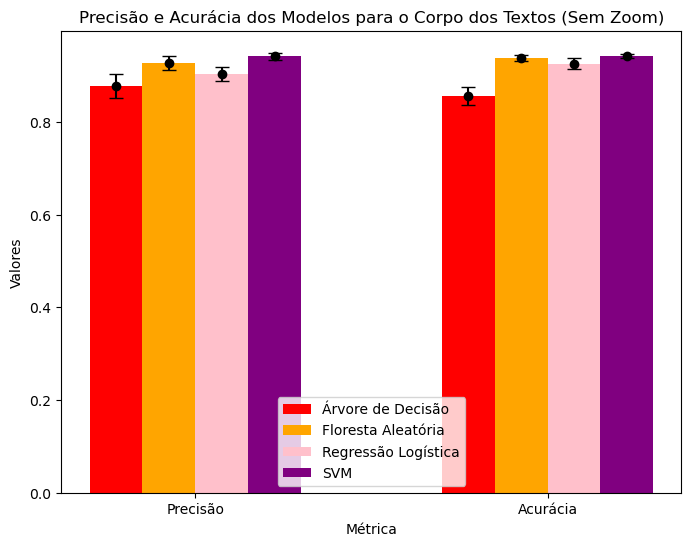

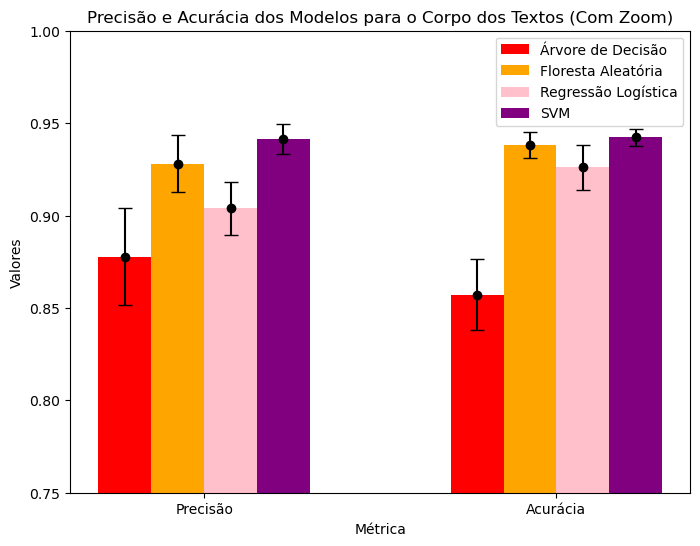

In [27]:
# Definindo os dados
accuracy_list = [acc_dt_mean, acc_rf_mean, acc_lr_mean, acc_svc_mean]
precision_list = [prec_dt_mean, prec_rf_mean, prec_lr_mean, prec_svc_mean]
acc_std_list = [acc_dt_std, acc_rf_std, acc_lr_std, acc_svc_std]
prec_std_list = [prec_dt_std, prec_rf_std, prec_lr_std, prec_svc_std]
model_labels = ['Árvore de Decisão', 'Floresta Aleatória', 'Regressão Logística', 'SVM']
colors = ['red', 'orange', 'pink', 'purple']

# Posições das barras para os grupos
x = np.arange(2)  # Um ponto para "Precisão" e outro para "Acurácia"
width = 0.15      # Largura das barras

# Criando o gráfico sem zoom
fig, ax = plt.subplots(figsize=(8, 6))
for i in range(len(model_labels)):
    # Precisão
    ax.bar(x[0] + i * width - (1.5 * width), precision_list[i], width, label=model_labels[i], color=colors[i])
    ax.errorbar(x[0] + i * width - (1.5 * width), precision_list[i], yerr=prec_std_list[i], fmt='o', color='black', capsize=5)
    # Acurácia
    ax.bar(x[1] + i * width - (1.5 * width), accuracy_list[i], width, color=colors[i])
    ax.errorbar(x[1] + i * width - (1.5 * width), accuracy_list[i], yerr=acc_std_list[i], fmt='o', color='black', capsize=5)

# Configurando os rótulos e título
ax.set_xlabel('Métrica')
ax.set_ylabel('Valores')
ax.set_title('Precisão e Acurácia dos Modelos para o Corpo dos Textos (Sem Zoom)')
ax.set_xticks(x)
ax.set_xticklabels(['Precisão', 'Acurácia'])
ax.legend()

# Exibindo o gráfico sem zoom
plt.show()

# Criando o gráfico com zoom
fig, ax = plt.subplots(figsize=(8, 6))
for i in range(len(model_labels)):
    # Precisão
    ax.bar(x[0] + i * width - (1.5 * width), precision_list[i], width, label=model_labels[i], color=colors[i])
    ax.errorbar(x[0] + i * width - (1.5 * width), precision_list[i], yerr=prec_std_list[i], fmt='o', color='black', capsize=5)
    # Acurácia
    ax.bar(x[1] + i * width - (1.5 * width), accuracy_list[i], width, color=colors[i])
    ax.errorbar(x[1] + i * width - (1.5 * width), accuracy_list[i], yerr=acc_std_list[i], fmt='o', color='black', capsize=5)

# Configurando os rótulos e título
ax.set_xlabel('Métrica')
ax.set_ylabel('Valores')
ax.set_title('Precisão e Acurácia dos Modelos para o Corpo dos Textos (Com Zoom)')
ax.set_xticks(x)
ax.set_xticklabels(['Precisão', 'Acurácia'])
ax.legend()

# Definindo o limite do eixo y para dar o "zoom"
plt.ylim(0.75, 1)

# Exibindo o gráfico com zoom
plt.show()